# Evaluating embedding distances
> Exploring distributions of distances and correlating them to other things we care about

# OTU-level distances

In [2]:
import anndata

# Load the mlrepo
mlrepo = anndata.read_h5ad("../data/mlrepo4.h5ad")
mlrepo

AnnData object with n_obs × n_vars = 10037 × 27105
    obs: 'ravel_black-hispanic', 'ravel_nugent-category', 'ravel_nugent-score', 'ravel_ph', 'ravel_white-black', 'dataset', 'gevers_ileum', 'gevers_pcdai-ileum', 'gevers_pcdai-rectum', 'gevers_rectum', 'sokol_healthy-cd', 'sokol_healthy-uc', 'yatsunenko_baby-age', 'yatsunenko_malawi-venezuela', 'yatsunenko_sex', 'yatsunenko_usa-malawi', 'hmp_gastro-oral', 'hmp_sex', 'hmp_stool-tongue-paired', 'hmp_sub-supragingivalplaque-paired', 'cho_control-ct-cecal', 'cho_control-ct-fecal', 'cho_penicillin-vancomycin-cecal', 'cho_penicillin-vancomycin-fecal', 'turnbaugh_obese-lean-all'
    var: 'k', 'p', 'c', 'o', 'f', 'g', 's', 'fasta'
    obsm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    varm: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s'
    obsp: 'E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', '

In [5]:
# Correlations between all distances in varp
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# Get all distance matrices from varp
distance_matrices = list(mlrepo.varp.keys())
print(f"Found {len(distance_matrices)} distance matrices in varp: {distance_matrices}")

# Create a dataframe to store correlations between all pairs of distance matrices
correlations = pd.DataFrame(index=distance_matrices, columns=distance_matrices)

# For each pair of distance matrices, compute the correlation
my_tqdm = tqdm(total=int(len(distance_matrices) * (len(distance_matrices) - 1) / 2))
for i, dist1 in enumerate(distance_matrices):
    # for j, dist2 in enumerate(distance_matrices):
    for j in range(i):
        dist2 = distance_matrices[j]
        # Get the distance matrices
        dm1 = mlrepo.varp[dist1]
        dm2 = mlrepo.varp[dist2]

        # Convert to 1D arrays (taking only the upper triangle to avoid redundancy)
        mask = np.triu_indices_from(dm1, k=1)
        dm1_flat = dm1[mask]
        dm2_flat = dm2[mask]

        # Compute correlation
        corr = np.corrcoef(dm1_flat, dm2_flat)[0, 1]
        correlations.loc[dist1, dist2] = corr
        correlations.loc[dist2, dist1] = corr
        my_tqdm.update(1)

Found 16 distance matrices in varp: ['E128', 'E16', 'E2', 'E32', 'E4', 'E64', 'E8', 'H128', 'H16', 'H2', 'H32', 'H4', 'H64', 'H8', 'dnabert-s', 'gg_tree_distances']


  0%|          | 0/120 [00:00<?, ?it/s]

In [7]:
# Save results

correlations.to_csv("../results/varp_distance_correlations.csv")

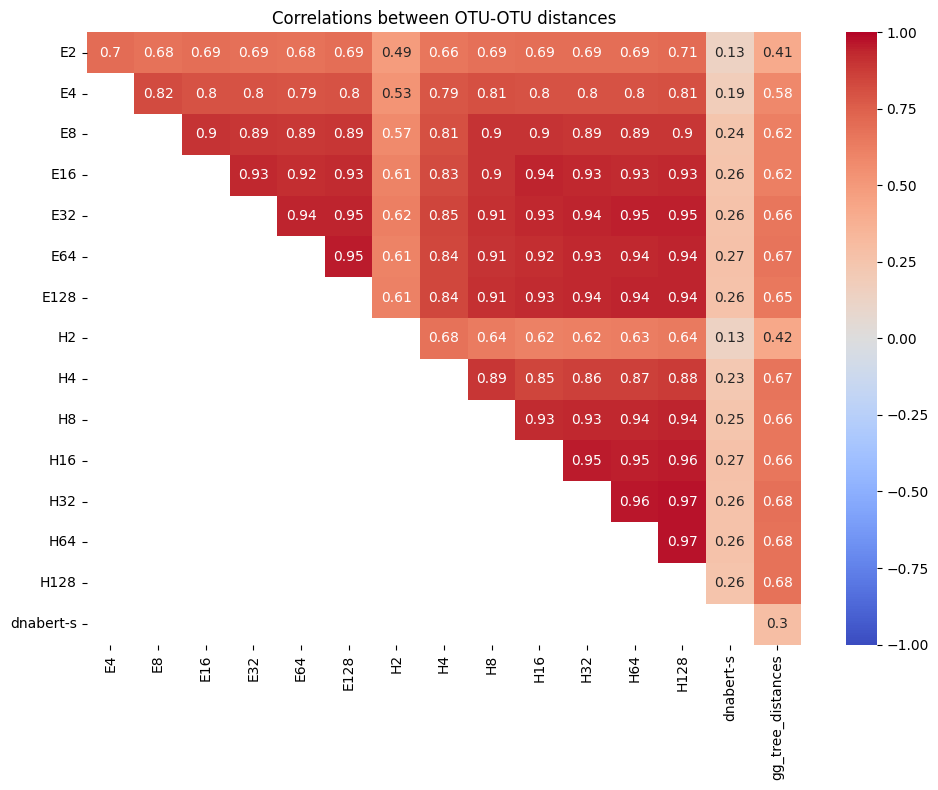

Summary of correlations:
Mean correlation: nan
Min correlation: nan
Max correlation: nan


<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

correlations = pd.read_csv("../results/varp_distance_correlations.csv", index_col=0)
# Fix indices
order = [
    "E2",
    "E4",
    "E8",
    "E16",
    "E32",
    "E64",
    "E128",
    "H2",
    "H4",
    "H8",
    "H16",
    "H32",
    "H64",
    "H128",
    "dnabert-s",
    "gg_tree_distances",
]
correlations = correlations.loc[order, order]

# Zero out lower triangle; drop last empty row and first column
correlations = correlations.where(np.triu(np.ones(correlations.shape)).astype(bool))
correlations = correlations.iloc[:-1, 1:]

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlations between OTU-OTU distances")
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of correlations:")
print(f"Mean correlation: {correlations.values.mean():.3f}")
print(f"Min correlation: {correlations.values.min():.3f}")
print(f"Max correlation: {correlations.values.max():.3f}")

# Save figure
plt.savefig("../figures/varp_distance_correlations.pdf", bbox_inches="tight", dpi=300)


# Sample-level distances

In [ ]:
import numpy as np
import pickle
from skbio.diversity import beta_diversity
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac

metrics = [
    "braycurtis",
    "jaccard",
    "unweighted_unifrac",
    "weighted_unifrac",
    "euclidean",
    "manhattan",
    "jensenshannon",
]

# Grab the pickled tree, downsample it to match our sampled mlrepo
tree = pickle.load(open("../data/mlrepo_tree.pkl", "rb"))

for metric in metrics:
    print(f"{metric}")
    if metric in ["unweighted_unifrac", "weighted_unifrac"]:
        f = weighted_unifrac if metric == "weighted_unifrac" else unweighted_unifrac
        dists = beta_diversity(metric, mlrepo.X, tree=tree, taxa=mlrepo.var.index).to_data_frame().values
    else:
        dists = beta_diversity(metric, mlrepo.X).to_data_frame().values
    assert dists.shape == (mlrepo.n_obs, mlrepo.n_obs)
    assert not np.isnan(dists).any()dr aya b
    mlrepo.obsp[metric] = dists